## 3d.1. Kiểm Tra Môi Trường & Cài Đặt

In [1]:
import sys
import torch
import warnings
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Tắt TensorFlow logs
warnings.filterwarnings('ignore')
print(f'Python: {sys.version}')
print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: Tesla T4
GPU Memory: 14.7 GB


## 3d.2. Import Thư Viện

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # AdamW đã chuyển sang torch.optim

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported')

Libraries imported


## 3d.3. Cấu Hình

In [3]:
# Model config
MODEL_NAME = 'distilbert-base-uncased'  # Nhẹ hơn bert-base-uncased 40%
MAX_LEN = 256  # Độ dài tối đa của sequence (BERT max = 512)
NUM_CLASSES = 2

# Training config
BATCH_SIZE = 32  # Tăng lên 32 nếu GPU có nhiều RAM
EPOCHS = 10  # Tăng lên 10 epochs với early stopping
EARLY_STOPPING_PATIENCE = 3  # Dừng nếu 3 epochs liên tiếp không cải thiện
LEARNING_RATE = 1e-5  # Giảm LR để training ổn định hơn (từ 2e-5 → 1e-5)
WARMUP_RATIO = 0.1  # 10% steps đầu để warmup
LABEL_SMOOTHING = 0.1  # Label smoothing để giảm overconfidence
VAL_SIZE = 0.15
SEED = 42

# Paths
DATA_DIR = '/kaggle/input/my-sentiment-dataset-csv'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train_augmented.csv')
TEST_CSV_PATH = os.path.join(DATA_DIR, 'test_original.csv')

OUT_DIR = '/kaggle/working/outputs_bert'
os.makedirs(OUT_DIR, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Configuration:')
print(f'   Model: {MODEL_NAME}')
print(f'   Device: {device}')
print(f'   Learning rate: {LEARNING_RATE}')
print(f'   Label smoothing: {LABEL_SMOOTHING}')
print(f'   Early stopping: {EARLY_STOPPING_PATIENCE} epochs patience')
print(f'   Max length: {MAX_LEN}')

print(f'   Output: {OUT_DIR}')

Configuration:
   Model: distilbert-base-uncased
   Device: cuda
   Learning rate: 1e-05
   Label smoothing: 0.1
   Early stopping: 3 epochs patience
   Max length: 256
   Output: /kaggle/working/outputs_bert


## 3d.4. Load Data

In [4]:
print('Loading CSV data...\n')

# Load train
df_train = pd.read_csv(TRAIN_CSV_PATH)
print(f'Train: {len(df_train):,} rows')

# Load test
df_test = pd.read_csv(TEST_CSV_PATH)
print(f'Test: {len(df_test):,} rows')

# Auto-detect columns
text_col = df_train.columns[0]
label_col = df_train.columns[1]
print(f'\nColumns: text="{text_col}", label="{label_col}"')

# Sample
print(f'\nSample:')
print(df_train.head(2))

Loading CSV data...

Train: 59,995 rows
Test: 10,000 rows

Columns: text="review", label="sentiment"

Sample:
                                              review sentiment
0  I've been watching this movie by hoping to fin...  negative
1  A famous orchestra conductor, Daniel Dareus, s...  positive


## 3d.5. Prepare Data

In [5]:
# Label mapping
label2idx = {'negative': 0, 'positive': 1}
idx2label = {0: 'negative', 1: 'positive'}

# Extract
train_texts = df_train[text_col].astype(str).tolist()
train_labels = df_train[label_col].map(label2idx).values

test_texts = df_test[text_col].astype(str).tolist()
test_labels = df_test[label_col].map(label2idx).values

print(f'Extracted:')
print(f'   Train: {len(train_texts):,} samples')
print(f'   Test: {len(test_texts):,} samples')

# Distribution
print(f'\nLabel distribution:')
for label, count in sorted(Counter(train_labels).items()):
    print(f'   Train {idx2label[label]}: {count:,} ({count/len(train_labels)*100:.1f}%)')
for label, count in sorted(Counter(test_labels).items()):
    print(f'   Test {idx2label[label]}: {count:,} ({count/len(test_labels)*100:.1f}%)')

Extracted:
   Train: 59,995 samples
   Test: 10,000 samples

Label distribution:
   Train negative: 29,997 (50.0%)
   Train positive: 29,998 (50.0%)
   Test negative: 5,000 (50.0%)
   Test positive: 5,000 (50.0%)


## 3d.6. Train/Val Split

In [6]:
print(f'Splitting train/val ({100*(1-VAL_SIZE):.0f}%/{100*VAL_SIZE:.0f}%)...\n')

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=train_labels
)

print(f'Split:')
print(f'   Train: {len(X_train):,}')
print(f'   Val: {len(X_val):,}')
print(f'   Test: {len(test_texts):,}')

Splitting train/val (85%/15%)...

Split:
   Train: 50,995
   Val: 9,000
   Test: 10,000


## 3d.7. Load Tokenizer & Tokenize

In [7]:
print(f'Loading tokenizer: {MODEL_NAME}\n')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print('Tokenizer loaded')
print(f'   Vocab size: {tokenizer.vocab_size:,}')
print(f'   Max model length: {tokenizer.model_max_length:,}')

# Test tokenize
sample = X_train[0][:100]
encoded = tokenizer(sample, truncation=True, max_length=MAX_LEN)
print(f'\nSample encoding:')
print(f'   Text: "{sample}"')
print(f'   Tokens: {len(encoded["input_ids"])}')

Loading tokenizer: distilbert-base-uncased



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded
   Vocab size: 30,522
   Max model length: 512

Sample encoding:
   Text: "Ahh, the dull t.v. shows and pilots that were slammed together in the 70's to make equally dull t.v."
   Tokens: 31


## 3d.8. Create Dataset Class

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print('Dataset class defined')

Dataset class defined


## 3d.9. Create DataLoaders

In [9]:
print('Creating datasets and dataloaders...\n')

train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('DataLoaders created:')
print(f'   Train batches: {len(train_loader)}')
print(f'   Val batches: {len(val_loader)}')
print(f'   Test batches: {len(test_loader)}')

Creating datasets and dataloaders...

DataLoaders created:
   Train batches: 1594
   Val batches: 282
   Test batches: 313


## 3d.10. Load Model

In [10]:
print(f'Loading model: {MODEL_NAME}\n')

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

print('Model loaded:')
print(f'   Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
print(f'   Device: {next(model.parameters()).device}')

Loading model: distilbert-base-uncased



E0000 00:00:1765862424.301084      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765862424.410760      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded:
   Total parameters: 66,955,010
   Trainable parameters: 66,955,010
   Device: cuda:0


## 3d.11. Setup Optimizer & Scheduler

In [11]:
# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8
)

# Scheduler với warmup
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print('Optimizer & Scheduler:')
print(f'   Learning rate: {LEARNING_RATE}')
print(f'   Total steps: {total_steps:,}')
print(f'   Warmup steps: {warmup_steps:,} ({WARMUP_RATIO*100:.0f}%)')

Optimizer & Scheduler:
   Learning rate: 1e-05
   Total steps: 15,940
   Warmup steps: 1,594 (10%)


## 3d.12. Training & Evaluation Functions

In [12]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    
    # Loss function với label smoothing
    loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    
    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # Không dùng labels trong model để tự tính loss với label smoothing
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Tính loss với label smoothing
        loss = loss_fn(outputs.logits, labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
    
    return np.mean(losses)


def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            losses.append(loss.item())
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print('Training functions defined')

    return np.mean(losses), acc, f1, all_preds, all_labels

## 3d.13. Training Loop

In [13]:
print('\n' + '='*80)
print('TRAINING STARTED')
print('='*80)
print(f'Model: {MODEL_NAME}')
print(f'Train samples: {len(train_dataset):,}')
print(f'Val samples: {len(val_dataset):,}')
print(f'Epochs: {EPOCHS}')
print(f'Early Stopping: Patience = {EARLY_STOPPING_PATIENCE} epochs')
print('='*80 + '\n')

best_val_f1 = 0
best_epoch = 0
epochs_without_improvement = 0
history = []

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 60)
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader, device)
    
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_f1': val_f1
    })
    
    print(f'\nResults:')
    print(f'   Train Loss: {train_loss:.4f}')
    print(f'   Val Loss: {val_loss:.4f}')
    print(f'   Val Acc: {val_acc:.4f}')
    print(f'   Val F1: {val_f1:.4f}')
    
    # Check improvement
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        epochs_without_improvement = 0
        
        model_save_path = os.path.join(OUT_DIR, 'best_model')
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f'   Saved best model (F1: {best_val_f1:.4f})')
    else:
        epochs_without_improvement += 1
        print(f'   No improvement ({epochs_without_improvement}/{EARLY_STOPPING_PATIENCE})')
    
    # Early stopping
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f'\nEarly stopping triggered!')
        print(f'   No improvement for {EARLY_STOPPING_PATIENCE} consecutive epochs')
        print(f'   Best Val F1: {best_val_f1:.4f} (Epoch {best_epoch})')
        break

print('\n' + '='*80)
if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
    print(f'TRAINING STOPPED EARLY (Epoch {epoch+1}/{EPOCHS})')
else:
    print('TRAINING COMPLETED!')
print(f'Best model from Epoch {best_epoch} with Val F1: {best_val_f1:.4f}')
print('='*80)


TRAINING STARTED
Model: distilbert-base-uncased
Train samples: 50,995
Val samples: 9,000
Epochs: 10
Early Stopping: Patience = 3 epochs


Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.4644
   Val Loss: 0.2876
   Val Acc: 0.8836
   Val F1: 0.8831
   Saved best model (F1: 0.8831)

Epoch 2/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.3475
   Val Loss: 0.2499
   Val Acc: 0.9034
   Val F1: 0.9032
   Saved best model (F1: 0.9032)

Epoch 3/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2984
   Val Loss: 0.2151
   Val Acc: 0.9241
   Val F1: 0.9241
   Saved best model (F1: 0.9241)

Epoch 4/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2653
   Val Loss: 0.2191
   Val Acc: 0.9272
   Val F1: 0.9272
   Saved best model (F1: 0.9272)

Epoch 5/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2430
   Val Loss: 0.2176
   Val Acc: 0.9296
   Val F1: 0.9296
   Saved best model (F1: 0.9296)

Epoch 6/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2303
   Val Loss: 0.2168
   Val Acc: 0.9313
   Val F1: 0.9313
   Saved best model (F1: 0.9313)

Epoch 7/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2226
   Val Loss: 0.2202
   Val Acc: 0.9329
   Val F1: 0.9329
   Saved best model (F1: 0.9329)

Epoch 8/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2176
   Val Loss: 0.2222
   Val Acc: 0.9334
   Val F1: 0.9334
   Saved best model (F1: 0.9334)

Epoch 9/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2148
   Val Loss: 0.2244
   Val Acc: 0.9317
   Val F1: 0.9317
   No improvement (1/3)

Epoch 10/10
------------------------------------------------------------


Training:   0%|          | 0/1594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Training functions defined

Results:
   Train Loss: 0.2125
   Val Loss: 0.2198
   Val Acc: 0.9346
   Val F1: 0.9346
   Saved best model (F1: 0.9346)

TRAINING COMPLETED!
Best model from Epoch 10 with Val F1: 0.9346


## 3d.14. Load Best Model & Evaluate on Test Set


Loading best model...

Best model loaded

TEST SET EVALUATION (KHÔNG AUGMENT - KHÁCH QUAN)


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Training functions defined

Test Performance:
   Loss: 0.2689
   Accuracy: 0.9167
   Macro F1: 0.9167

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      5000
    positive       0.92      0.92      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



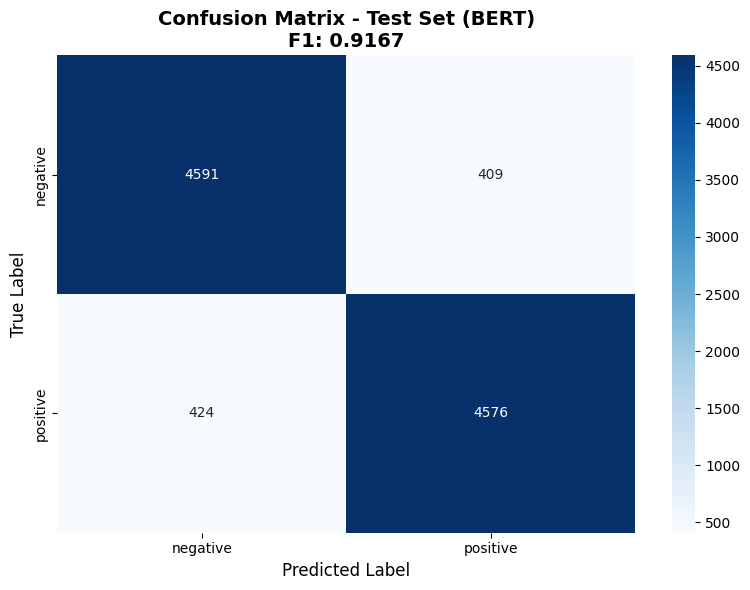

In [14]:
print('\nLoading best model...\n')

model_save_path = os.path.join(OUT_DIR, 'best_model')
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
model = model.to(device)

print('Best model loaded')

# Evaluate on test set
print('\n' + '='*80)
print('TEST SET EVALUATION (KHÔNG AUGMENT - KHÁCH QUAN)')
print('='*80)

test_loss, test_acc, test_f1, test_preds, test_true = eval_model(model, test_loader, device)

print(f'\nTest Performance:')
print(f'   Loss: {test_loss:.4f}')
print(f'   Accuracy: {test_acc:.4f}')
print(f'   Macro F1: {test_f1:.4f}')

print(f'\nClassification Report:')
print(classification_report(test_true, test_preds, target_names=['negative', 'positive']))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title(f'Confusion Matrix - Test Set (BERT)\nF1: {test_f1:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'test_confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print('='*80)

## 3d.15. Training History Visualization

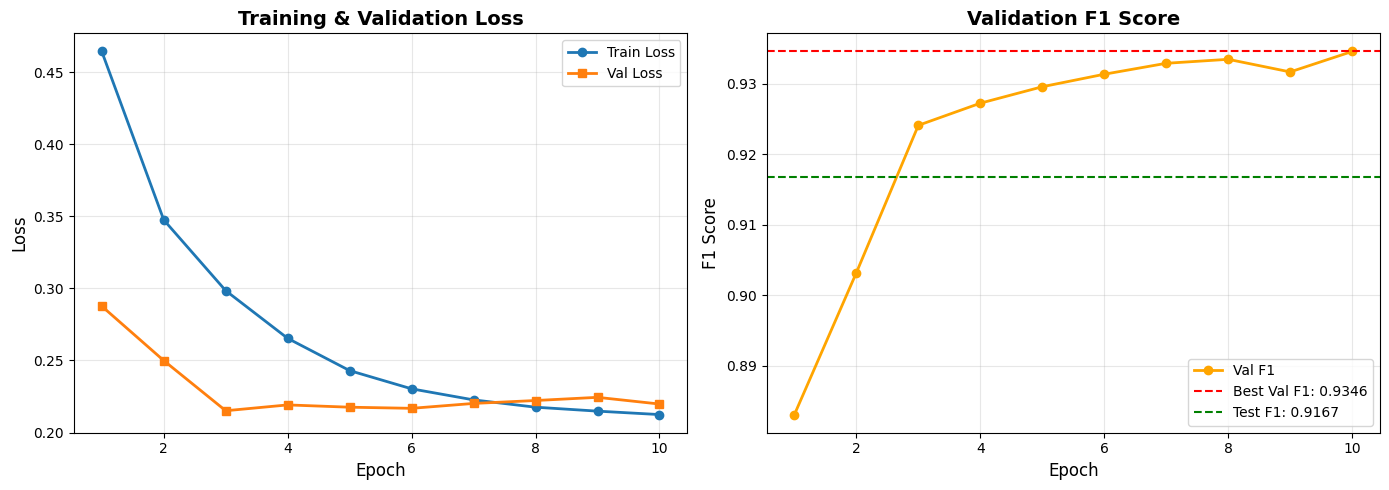

Training history saved


In [15]:
# Convert history to DataFrame
df_history = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(df_history['epoch'], df_history['train_loss'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(df_history['epoch'], df_history['val_loss'], marker='s', label='Val Loss', linewidth=2)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1
axes[1].plot(df_history['epoch'], df_history['val_f1'], marker='o', color='orange', linewidth=2, label='Val F1')
axes[1].axhline(y=best_val_f1, color='r', linestyle='--', label=f'Best Val F1: {best_val_f1:.4f}')
axes[1].axhline(y=test_f1, color='g', linestyle='--', label=f'Test F1: {test_f1:.4f}')
axes[1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Training history saved')

## 3d.16. Save Metadata

In [16]:
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'DistilBERT',
    'num_classes': NUM_CLASSES,
    'max_length': MAX_LEN,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'warmup_ratio': WARMUP_RATIO,
    'best_val_f1': float(best_val_f1),
    'test_accuracy': float(test_acc),
    'test_f1': float(test_f1),
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'train_augmented': True,
    'test_augmented': False,
    'data_source': 'CSV (split_augmented_data)',
    'device': str(device)
}

meta_path = os.path.join(OUT_DIR, 'meta.json')
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print('Metadata saved')

Metadata saved


## 3d.17. Summary

In [17]:
print('\n' + '='*80)
print('BERT TRAINING COMPLETED!')
print('='*80)

print(f'\nConfiguration:')
print(f'   Model: {MODEL_NAME}')
print(f'   Max length: {MAX_LEN}')
print(f'   Batch size: {BATCH_SIZE}')
print(f'   Epochs: {EPOCHS}')
print(f'   Learning rate: {LEARNING_RATE}')

print(f'\nPerformance:')
print(f'   Best Val F1: {best_val_f1:.4f}')
print(f'   Test Accuracy: {test_acc:.4f}')
print(f'   Test F1: {test_f1:.4f}')

print(f'\nSaved files in {OUT_DIR}:')
for item in sorted(os.listdir(OUT_DIR)):
    item_path = os.path.join(OUT_DIR, item)
    if os.path.isfile(item_path):
        size_kb = os.path.getsize(item_path) / 1024
        print(f'   - {item:30s} ({size_kb:>8.1f} KB)')
    elif os.path.isdir(item_path):
        print(f'   - {item}/ (directory)')

print('\n' + '='*80)


BERT TRAINING COMPLETED!

Configuration:
   Model: distilbert-base-uncased
   Max length: 256
   Batch size: 32
   Epochs: 10
   Learning rate: 1e-05

Performance:
   Best Val F1: 0.9346
   Test Accuracy: 0.9167
   Test F1: 0.9167

Saved files in /kaggle/working/outputs_bert:
   - best_model/ (directory)
   - meta.json                      (     0.5 KB)
   - test_confusion_matrix.png      (    52.4 KB)
   - training_history.png           (    96.0 KB)

